# Elastica paper figures
In this notebook the figures from the paper [Keemink & van Rossum (2015) - etc.) are reproduced, and in the process it is shown how to use the elastica library and some general widgets. 

Necessary libraries:
- matplotlib
- scipy
- numpy
- HoloViews (http://holoviews.org/)

In [2]:
import holoviews as hv
%load_ext holoviews.ipython
%output widgets='embed' holomap='widgets' size=150 fig='png'
import BAYESSUR as BS
import pylab    as pl
from   pylab import exp,cos,sin,pi,tan

First, let's set the basic model parameters

In [3]:
Ac = 1     # basic tuning magnitude
Kc = 0.5   # basic tuning width (lower is wider)
a  = 0.1  # modulation strength
E0 = 4     # modulation offset
N  = 128    # number of neurons per location

Define basic plotting functions

In [4]:
def plotsceneandresponses(scene,iLoc):
    ''' plots the scene and the responses plus underlying drive and modulations for location iLoc
    Inputs
    -----------------
    - scene: the scene to plot
    - iLoc: bar position to plot responses and drives+modulations for
    
    Output
    ------------------
    - Holoviews object of the Figure
    '''
    # get the scene plot
    ScenePlot = scene.plotscene()

    # simulate the scene for location iLoc (i.e. the bar number), and assuming we're not on a torus
    scene.simulate(iLoc,torus='off')

    # get the preferred orientations
    pref        = scene.ang/pi

    # get the drive, modulation, and final response of iLoc
    centerdrive = hv.Curve(zip(pref,scene.FRc[iLoc,:]),label='center drive')
    surroundmod = hv.Curve(zip(pref,scene.FRs[iLoc,:]),label='flanker modulation')
    response    = hv.Curve(zip(pref,scene.FR[iLoc,:]),label='response')

    # make the response plot
    ResponsePlot = surroundmod*centerdrive*response

    # get the modulation contributions
    ModContributions = scene.plotlocalmod(iLoc,torus='off')

    # plot 
    return ScenePlot+ResponsePlot+ModContributions
    

### Example scenes
Setting up a few example scenes. 

3 bars

:Layout
   .Overlay.I   :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.Flanker_modulation :Curve   [x]   (y)
      .Curve.Center_drive       :Curve   [x]   (y)
      .Curve.Response           :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
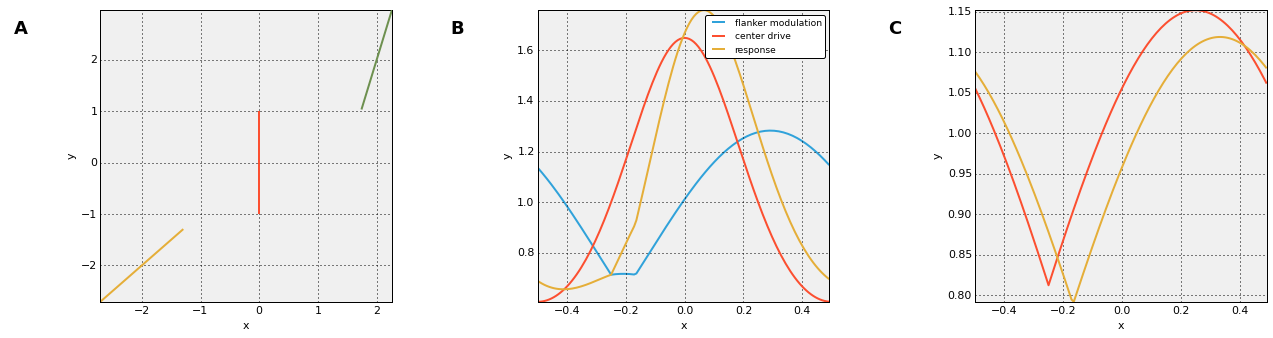

In [6]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them

# set bar orientations
a1 = 0*pi/180 # bar 1 orientation
a2 = 45*pi/180 # bar 2 orientation
a3 = 15*pi/180 # bar 3 orientation
A  = pl.array([a1,a2,a3])

# set bar positions (x and y positions)
X = pl.array([[0,0],[-2,-2],[2,2]])

# Setup the scene
scene_3b = BS.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# plot
plotsceneandresponses(scene_3b,iLoc=0)

A center bar and n surround bars, with a center and surround orientation. The surround orientation rotates the entire surround.

:Layout
   .Overlay.I   :Overlay
      .Curve.I    :Curve   [x]   (y)
      .Curve.II   :Curve   [x]   (y)
      .Curve.III  :Curve   [x]   (y)
      .Curve.IV   :Curve   [x]   (y)
      .Curve.V    :Curve   [x]   (y)
      .Curve.VI   :Curve   [x]   (y)
      .Curve.VII  :Curve   [x]   (y)
      .Curve.VIII :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.Flanker_modulation :Curve   [x]   (y)
      .Curve.Center_drive       :Curve   [x]   (y)
      .Curve.Response           :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
      .Curve.V   :Curve   [x]   (y)
      .Curve.VI  :Curve   [x]   (y)
      .Curve.VII :Curve   [x]   (y)
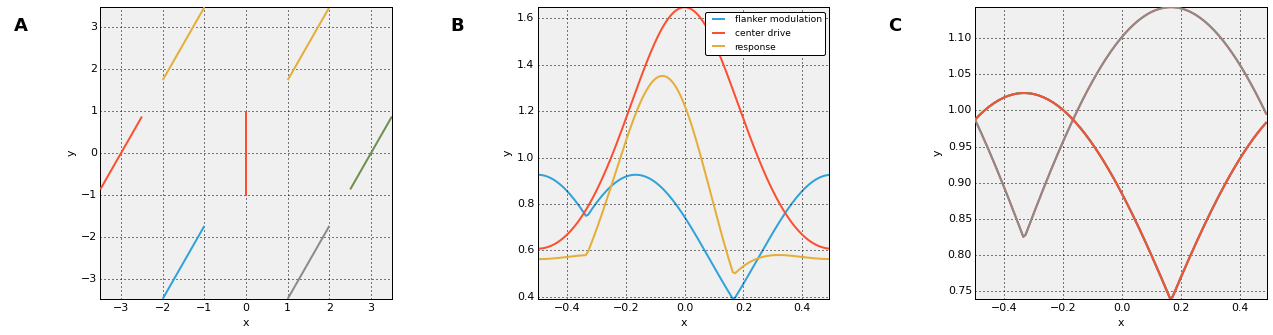

In [7]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them

# set some scene parameters
ns = 6 # number of surround bars
R  = 3 # surround distance

# set bar orientations
c = 0*pi/180 # center bar orientation
s = 30*pi/180 # surround bars orientation
A  = pl.zeros(ns+1) # define all bars as having zero degree orientation
A[0] = c # sets first bar as center orientation
A[1:] = pl.ones(ns)*s # sets all other bars as surround orientation

# set bar positions (x and y positions)
X = pl.zeros((ns+1,2)) # set all bars positions to [0,0]
pos = pl.linspace(0,2*pi,ns+1)[:-1]+s # flanker angular positions
X[1:,0]= R*sin(pos) # sets x positions
X[1:,1]= R*cos(pos) # sets y positions
# (position of center is assumed to be [0,0])

# Setup the scene
scene_sur = BS.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# plot
plotsceneandresponses(scene_sur,iLoc=0)